In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data = pd.read_csv("housingtrain.csv")

In [5]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split


In [7]:
data_copy = data.copy()

In [8]:
data_copy.MasVnrArea = data_copy.MasVnrArea.fillna(0)

In [9]:
cat_cols_fill_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
                     'GarageCond', 'GarageQual', 'GarageFinish', 'GarageType',
                     'BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtQual', 'BsmtCond',
                     'MasVnrType']

In [10]:
for cat in cat_cols_fill_none:
    data_copy[cat] = data_copy[cat].fillna("None")
    

In [11]:
data_copy.isna().sum().sort_values(ascending=False).head()


LotFrontage    259
GarageYrBlt     81
Electrical       1
SalePrice        0
ExterCond        0
dtype: int64

In [12]:
data_copy = data_copy.drop(data_copy['LotFrontage']
                                     [data_copy['LotFrontage']>200].index)


In [13]:
data_copy = data_copy.drop(data_copy['LotArea']
                                     [data_copy['LotArea']>100000].index)
data_copy = data_copy.drop(data_copy['BsmtFinSF1']
                                     [data_copy['BsmtFinSF1']>4000].index)
data_copy = data_copy.drop(data_copy['TotalBsmtSF']
                                     [data_copy['TotalBsmtSF']>6000].index)
data_copy = data_copy.drop(data_copy['1stFlrSF']
                                     [data_copy['1stFlrSF']>4000].index)
#data_copy = data_copy.drop(data_copy.GrLivArea[(data_copy['GrLivArea']>4000) & (['target']<300000)].index)
data_copy = data_copy.drop(data_copy.LowQualFinSF
                                     [data_copy['LowQualFinSF']>550].index)

In [14]:
data_copy['SalePrice'] = np.log(data_copy['SalePrice'])
data_copy = data_copy.rename(columns={'SalePrice': 'SalePrice_log'})


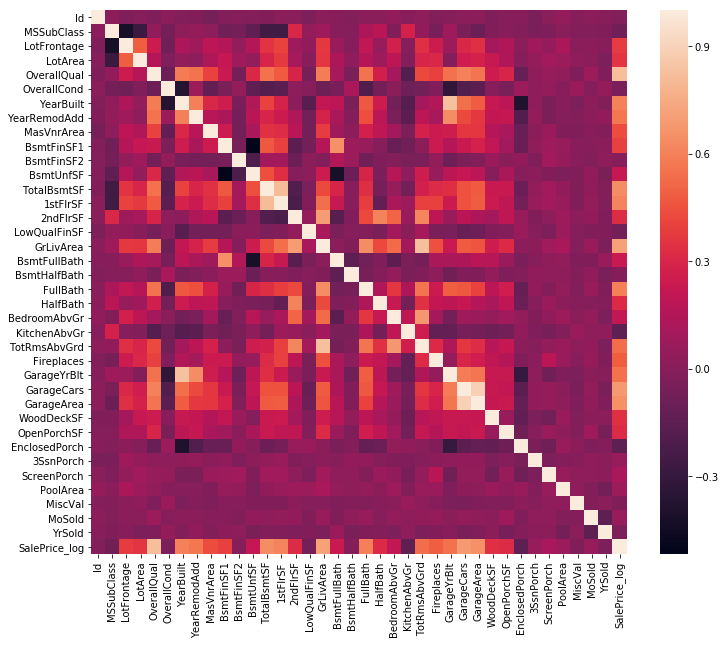

In [15]:
transformed_corr = data_copy.corr()
plt.figure(figsize=(12,10))
sns.heatmap(transformed_corr)


In [16]:
attributes_drop = ['SalePrice_log', 'MiscVal', 'MSSubClass', 'MoSold', 'YrSold', 
                   'GarageArea', 'GarageYrBlt', 'TotRmsAbvGrd'] # high corr with other attributes
X = data_copy.drop(attributes_drop, axis=1)
y = data_copy.SalePrice_log
X = pd.get_dummies(X)
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)


In [17]:
my_imputer = SimpleImputer()
train_X = my_imputer.fit_transform(train_X)
val_X = my_imputer.transform(val_X)

In [20]:
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [22]:
def inv_y(transformed_y):
    return np.exp(transformed_y)


In [23]:
lasso_model = Lasso(alpha=0.0005, random_state=5)
lasso_model.fit(train_X, train_y)
lasso_val_predictions = lasso_model.predict(val_X)
lasso_val_mae = mean_absolute_error(inv_y(lasso_val_predictions), inv_y(val_y))


In [24]:
lasso_val_mae

13618.265389360995

In [25]:
from sklearn.model_selection import cross_val_score

imputer = SimpleImputer()
imputed_X = imputer.fit_transform(X)
n_folds = 10

scores = cross_val_score(lasso_model, imputed_X, y, scoring='neg_mean_squared_error', 
                         cv=n_folds)
lasso_mae_scores = np.sqrt(-scores)

print('Mean RMSE = ' + str(lasso_mae_scores.mean().round(decimals=3)))
print('Error std deviation = ' +str(lasso_mae_scores.std().round(decimals=3)))


Mean RMSE = 0.119
Error std deviation = 0.03


In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'alpha': [0.0007, 0.0005, 0.005]}]
top_reg = Lasso()

grid_search = GridSearchCV(top_reg, param_grid, cv=5, 
                           scoring='neg_mean_squared_error')

grid_search.fit(imputed_X, y)

grid_search.best_params_

{'alpha': 0.0007}

In [28]:
test_data = pd.read_csv("housingtest.csv")


In [29]:
test_X = test_data.copy()

test_X.MasVnrArea = test_X.MasVnrArea.fillna(0)

for cat in cat_cols_fill_none:
    test_X[cat] = test_X[cat].fillna("None")

if 'SalePrice_log' in attributes_drop:
    attributes_drop.remove('SalePrice_log')

test_X = test_data.drop(attributes_drop, axis=1)

test_X = pd.get_dummies(test_X)

final_train, final_test = X.align(test_X, join='left', axis=1)

final_test_imputed = my_imputer.transform(final_test)


In [30]:
final_model = Lasso(alpha=0.0005, random_state=5)

final_train_imputed = my_imputer.fit_transform(final_train)

final_model.fit(final_train_imputed, y)

Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=5,
      selection='cyclic', tol=0.0001, warm_start=False)

In [31]:
test_preds = final_model.predict(final_test_imputed)

output = pd.DataFrame({'Id': test_data.Id,'SalePrice': inv_y(test_preds)})

output.to_csv('predictPK.csv', index=False)
